In [ ]:
%load_ext autoreload
%autoreload 2

In [39]:
import sys
sys.path.append('..')

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict

import pickle
import plot_params

### Utilities

In [41]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

In [42]:
def get_runtime_improvement(ast_results, ucs_results):
    assert ast_results['index'].equals(ucs_results['index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    # Get the expansion arrays.
    ucs_expansions = ucs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    
    # Obtain indexes that would sort the UCS expansions array.
    idxs = np.argsort(ucs_expansions.values)
    
    # Use indexes to sort UCS and A* expansions arrays and compute improvement. 
    ucs_expansions_sorted = ucs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    
    improvement = (ucs_expansions_sorted / ast_expansions_sorted)
    return improvement, ast_expansions_sorted, ucs_expansions_sorted

In [43]:
def get_path_cost_increase(ast_results, ucs_results):
    assert ast_results['index'].equals(ucs_results['index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    print(ucs_results.columns)
    
    # Get the expansion arrays.
    ucs_path_cost = ucs_results['path_cost']
    ast_path_cost = ast_results['path_cost']
    
    # Obtain indexes that would sort the ucs expansions array.
    idxs = np.argsort(ucs_path_cost.values)
    
    # Use indexes to sort ucs and A* expansions arrays and compute improvement. 
    ucs_path_cost_sorted = ucs_path_cost.values[idxs]
    ast_path_cost_sorted = ast_path_cost.values[idxs]
    
    increase = (ast_path_cost_sorted / ucs_path_cost_sorted)
    return increase, ast_path_cost_sorted, ucs_path_cost_sorted

In [8]:
def get_feature_names(quantized_features):
    feature_names = ['source_identity']
    for x in quantized_features:
        split = x.split('_')
        if 'source' in split:
            continue
        else:
            feat = '_'.join(split[:-1])
            if feat not in feature_names:
                feature_names.append(feat)
    return feature_names

In [9]:
def get_feature_value_pairs(xs):
    obj = {}
    for x in xs:
        split = x.split('_')
        if 'source' in split:
            if 'present' in split:
                feature = 'source_identity'
                value = '_'.join(split[2:3])
                if feature in obj:
                    obj[feature].append(value)
                else:
                    obj[feature] = [value]
        else:
            feature = '_'.join(split[:-1])
            value = split[-1]
            obj[feature] = value
    return obj

In [44]:
def get_feature_names(quantized_features):
    feature_names = ['source_identity']
    for x in quantized_features:
        split = x.split('_')
        if 'source' in split:
            continue
        else:
            feat = '_'.join(split[:-1])
            if feat not in feature_names:
                feature_names.append(feat)
    return feature_names

In [45]:
def get_feature_value_pairs(xs):
    obj = {}
    for x in xs:
        split = x.split('_')
        if 'source' in split:
            if 'present' in split:
                feature = 'source_identity'
                value = '_'.join(split[2:3])
                if feature in obj:
                    obj[feature].append(value)
                else:
                    obj[feature] = [value]
        else:
            feature = '_'.join(split[:-1])
            value = split[-1]
            obj[feature] = value
    return obj

### Load data

In [46]:
# Load results from running adversarial search on bot dataset.
results = load_results('../out/bots_1k.pickle')

### Add table with adversarial examples

In [56]:
search_results = results[0]['search_results']
features = results[0]['features']

feature_names = get_feature_names(features)
changed_features = set()

df = pd.DataFrame(columns=['confidence'] + feature_names)

for i, row in search_results.iterrows():
    
    # Find which features are set.
    original = row['x_features'].astype(bool)
    adversarial = row['x_adv_features'].astype(bool)
    
    # Get a dictionary of features (keys) and values.
    orig_feat_vals = get_feature_value_pairs(features[original])
    adv_feat_vals = get_feature_value_pairs(features[adversarial])
        
    # The code below checks if there are at least 2 changed features.
    changed = 0
    temp_changed_features = set()
    
    for k in orig_feat_vals.keys():
        if orig_feat_vals[k] != adv_feat_vals[k]:
            changed += 1
            temp_changed_features.add(k)
            
    if changed < 2:
        continue
        
    # Add the confidence scores to ease append to the dataframe.
    orig_feat_vals['confidence'] = row['init_confidence']
    adv_feat_vals['confidence'] = row['adv_confidence']
    
    # Keep track of changed features.
    changed_features = changed_features.union(temp_changed_features)
    
    # Append to the dataframe.
    df = df.append(orig_feat_vals, ignore_index=True)
    df = df.append(adv_feat_vals, ignore_index=True)

# Drop unchanged features.
unchanged_features = set(feature_names) - changed_features
df = df.drop(columns=unchanged_features)

# Convert to latex. 
res = df.to_latex(index=False)
# print(res)
df

,confidence,source_identity,user_tweeted,user_retweeted,user_favourited,user_replied,lists_per_user,age_of_account_in_days,urls_count
0,0.120752,"[other, browser, mobile]","(6.0, 7.0]","(-0.001, 1.0]","(52.0, 207.8]","(-0.001, 1.0]","(0.011, 0.0143]","(2127.598, 2264.455]","(5.0, 6.0]"
1,0.544546,"[browser, mobile]","(6.0, 7.0]","(-0.001, 1.0]","(207.8, 476.143]","(-0.001, 1.0]","(0.011, 0.0143]","(2127.598, 2264.455]","(5.0, 6.0]"
2,0.008606,[other],"(-0.001, 1.0]","(19.0, 32.0]","(-0.001, 4.0]","(26.0, 42.0]","(0.024, 0.0329]","(766.122, 849.108]","(16.0, 24.2]"
3,0.526738,"[mobile, osn]","(-0.001, 1.0]","(12.0, 19.0]","(-0.001, 4.0]","(26.0, 42.0]","(0.0188, 0.024]","(766.122, 849.108]","(16.0, 24.2]"
4,0.118470,"[other, browser, mobile]","(20.0, 27.0]","(19.0, 32.0]","(35990.095, 211890.704]","(18.0, 26.0]","(0.024, 0.0329]","(2450.073, 3332.802]","(16.0, 24.2]"
5,0.578171,"[browser, mobile]","(20.0, 27.0]","(12.0, 19.0]","(35990.095, 211890.704]","(18.0, 26.0]","(0.024, 0.0329]","(2450.073, 3332.802]","(16.0, 24.2]"
6,0.050031,[marketing],"(55.6, 766.0]","(-0.001, 1.0]","(772.24, 1164.881]","(-0.001, 1.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
7,0.511897,"[mobile, osn]","(27.0, 55.6]","(-0.001, 1.0]","(772.24, 1164.881]","(-0.001, 1.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
8,0.009900,[automation],"(13.0, 16.0]","(-0.001, 1.0]","(4.0, 52.0]","(-0.001, 1.0]","(0.05, 0.0962]","(1177.447, 1269.787]","(12.0, 16.0]"
9,0.512774,"[mobile, osn]","(13.0, 16.0]","(-0.001, 1.0]","(4.0, 52.0]","(1.0, 2.0]","(0.05, 0.0962]","(1269.787, 1384.307]","(12.0, 16.0]"


### Table with adversarial examples

In [11]:
ast_results = group_by_key(results, 'epsilon').get(1)
results_bin = group_by_key(ast_results, 'bins').get(FOCUS_BINS)[0]

search_results = results_bin['search_results']
features = results_bin['features']

feature_names = get_feature_names(features)
changed_features = set()

df = pd.DataFrame(columns=['confidence'] + feature_names)

for i, row in search_results.iterrows():
    
    # Find which features are set.
    original = row['x_features'].astype(bool)
    adversarial = row['x_adv_features'].astype(bool)
    
    # Get a dictionary of features (keys) and values.
    orig_feat_vals = get_feature_value_pairs(features[original])
    adv_feat_vals = get_feature_value_pairs(features[adversarial])
        
    # The code below checks if there are at least 2 changed features.
    changed = 0
    temp_changed_features = set()
    
    try:
        for k in orig_feat_vals.keys():
            if orig_feat_vals[k] != adv_feat_vals[k]:
                changed += 1
                temp_changed_features.add(k)
                
    except KeyError as e:
        print('KeyError', e)
        continue
            
    if changed < 2:
        continue
        
    # Add the confidence scores to ease append to the dataframe.
    orig_feat_vals['confidence'] = row['init_confidence']
    adv_feat_vals['confidence'] = row['adv_confidence']
    
    # Keep track of changed features.
    changed_features = changed_features.union(temp_changed_features)
    
    # Append to the dataframe.
    df = df.append(orig_feat_vals, ignore_index=True)
    df = df.append(adv_feat_vals, ignore_index=True)

# Drop unchanged features.
unchanged_features = set(feature_names) - changed_features
df = df.drop(columns=unchanged_features)
df

# Convert to latex. 
# res = df.to_latex(index=False)


,confidence,user_tweeted,user_retweeted,user_replied,lists_per_user,age_of_account_in_days,urls_count
0,0.005803,"(-0.001, 1.0]","(19.0, 32.0]","(26.0, 42.0]","(0.024, 0.0329]","(766.122, 849.108]","(16.0, 24.2]"
1,0.500861,"(-0.001, 1.0]","(9.0, 12.0]","(26.0, 42.0]","(0.0188, 0.024]","(766.122, 849.108]","(16.0, 24.2]"
2,0.038091,"(55.6, 766.0]","(-0.001, 1.0]","(-0.001, 1.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
3,0.530297,"(27.0, 55.6]","(-0.001, 1.0]","(1.0, 2.0]","(0.05, 0.0962]","(1384.307, 1492.455]","(56.0, 806.0]"
4,0.007509,"(13.0, 16.0]","(-0.001, 1.0]","(-0.001, 1.0]","(0.05, 0.0962]","(1177.447, 1269.787]","(12.0, 16.0]"
5,0.511965,"(13.0, 16.0]","(2.0, 3.0]","(1.0, 2.0]","(0.05, 0.0962]","(1269.787, 1384.307]","(12.0, 16.0]"
6,0.010872,"(16.0, 20.0]","(-0.001, 1.0]","(-0.001, 1.0]","(0.00373, 0.00485]","(503.551, 645.233]","(16.0, 24.2]"
7,0.528285,"(20.0, 27.0]","(-0.001, 1.0]","(1.0, 2.0]","(0.00485, 0.00594]","(503.551, 645.233]","(16.0, 24.2]"
8,0.002340,"(55.6, 766.0]","(-0.001, 1.0]","(-0.001, 1.0]","(0.024, 0.0329]","(1939.803, 2127.598]","(56.0, 806.0]"
9,0.500105,"(27.0, 55.6]","(-0.001, 1.0]","(1.0, 2.0]","(0.0188, 0.024]","(1939.803, 2127.598]","(24.2, 56.0]"


### Plot results over different bins

#### Record stats and metrics over different bins

In [12]:
results_by_bins = group_by_key(results, 'bins')
attack_perf_df = pd.DataFrame(columns=['bins', 'index', 'expansions', 'improvement', 'eps'])
clf_perf_df = pd.DataFrame(columns=['bins', 'accuracy', 'robustness'])
costs_df = pd.DataFrame(columns=['bins', 'index', 'eps', 'robustness', 'pathcost', 'pathcostincrease'])

models = []
ucs_results_by_bins = group_by_key(group_by_key(results, 'epsilon').get(0), 'bins')
for bins, items in results_by_bins.items():
    clf_perf_df = clf_perf_df.append({
            'bins': bins,
            'accuracy': items[0]['clf_test_score'],
        }, ignore_index=True)
    models.append(items[0]['classifier'])
    
    for item in items:
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins[bins][0]['search_results']
        
        ast_results = ast_results.sort_values('index')
        ucs_results = ucs_results.sort_values('index')
        assert ast_results['index'].equals(ucs_results['index'])
        
        item_data = zip(
            ast_results['index'],
            ast_results['nodes_expanded'],
            ucs_results['nodes_expanded'])
        
        # Record attack runtime performance vs. UCS
        for index, ast_expansions, ucs_expansions in item_data:           
            attack_perf_df = attack_perf_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'expansions': ast_expansions,
                    'improvement': ucs_expansions / ast_expansions,
                },
                ignore_index=True
            )
        
        # Record attack cost performance vs. UCS
        for index, ast_path_cost, ucs_path_cost in zip(
                ast_results['index'], ast_results['path_cost'], ucs_results['path_cost']):

            example = list(ast_results.query('index==%d' % index)['x_features'])[0]
            robustness = np.abs(item['classifier'].decision_function([example])[0]) \
                / np.linalg.norm(item['classifier'].coef_[0], ord=item['q_norm'])
            
            ucs_results.sort_values
            costs_df = costs_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'robustness': robustness,
                    'pathcost': ucs_path_cost,
                    'pathcostincrease': ast_path_cost / ucs_path_cost
                },
                ignore_index=True
            )

In [13]:
costs_df.pathcostincrease.max()

1.5

#### Compute model gradient sharpness

In [14]:
coefs = np.array([model.coef_[0] for model in models])
coefs_norm = []
for coef_vec in coefs:
    coef_vec_norm = np.array(coef_vec)
    coef_vec_norm += np.abs(np.min(coef_vec_norm))
    coef_vec_norm /= np.sum(np.abs(coef_vec_norm))
    coefs_norm.append(coef_vec_norm)
    
coefs_norm = np.array(coefs_norm)
sharpness = np.array([np.ediff1d(coef).mean() for coef in coefs_norm])

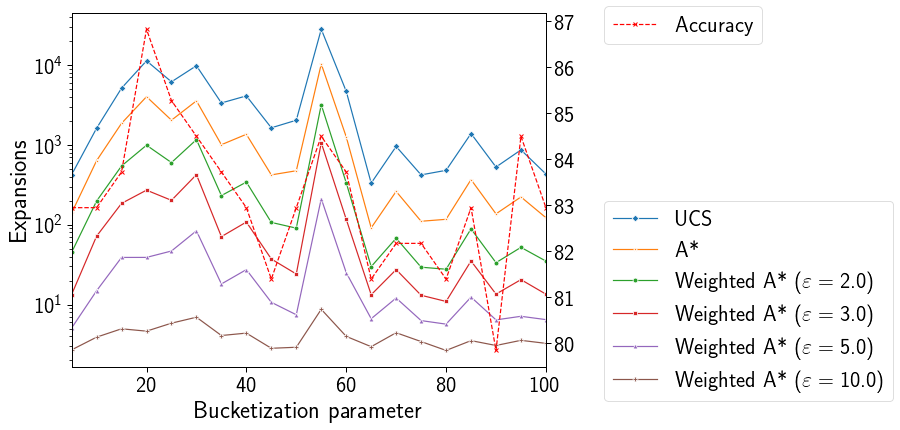

In [15]:
fig, ax = plt.subplots()

sns.lineplot(data=attack_perf_df.query('eps == 0'),
             x='bins', y='expansions', ax=ax, label='UCS', ci=None,
             marker=MARKERS[0])

sns.lineplot(data=attack_perf_df.query('eps == 1'),
             x='bins', y='expansions', ax=ax, label='A*', ci=None, 
             marker=MARKERS[1])

for i, eps in enumerate(WEIGHTED_EPSILONS):
    sns.lineplot(data=attack_perf_df.query('{0} - 0.1 < eps < {0} + 0.1'.format(eps)),
                 x='bins', y='expansions', ax=ax,
                 label='Weighted A* ($\\varepsilon = %1.1f$)' % eps,
                 ci=None, marker=MARKERS[i + 2])

if BEST_FIRST_EPSILON is not None:
    sns.lineplot(data=attack_perf_df.query('eps == %d' % BEST_FIRST_EPSILON),
                 x='bins', y='expansions', ax=ax, label='Best-first',
                 ci=None)

ax.set_ylabel('Expansions')
ax.set_xlabel('Bucketization parameter')
ax.set_xlim(5, 100)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.1, 0.5))

ax2 = ax.twinx()
ax2.plot(clf_perf_df.bins, clf_perf_df.accuracy,
         label='Accuracy',
         linestyle='--', color='red', marker='x')
# ax2.set_yscale('log')
ax2.legend(loc=2, bbox_to_anchor=(1.1, 1.05))

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    fig.savefig('../out/bots_different_bins_perf_band_%s.pdf' % BAND)

### Plot results for one bin

In [16]:
# Group the results by the required key.
results_by_key = group_by_key(results, 'epsilon')

improvements = {}
ast_sorts = {}
for epsilon, items in results_by_key.items():
    for item in items:
        if item['bins'] != FOCUS_BINS:
            continue
        
        ast_results = item['search_results']
        ucs_results = ucs_results_by_bins.get(FOCUS_BINS)[0]['search_results']
        improvement = get_runtime_improvement(ast_results, ucs_results)
        improvements[epsilon] = improvement[0]
        ast_sorts[epsilon] = improvement[1]
        
ucs_sort = improvement[2]

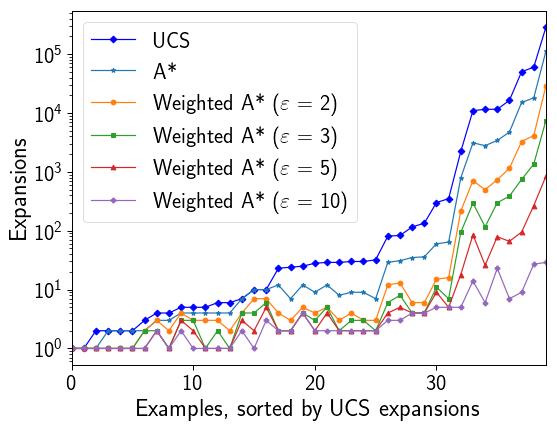

In [17]:
fig, ax = plt.subplots()

ax.plot(ucs_sort, color='blue', label='UCS', marker=MARKERS[0])
ax.plot(ast_sorts[1], label='A*', marker=MARKERS[1])

for i, eps in enumerate(WEIGHTED_EPSILONS):
    ast_sort = ast_sorts[eps]
    ax.plot(ast_sort, label='Weighted A* ($\\varepsilon$ = {})'.format(eps), marker=MARKERS[i + 2])
    
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Expansions')
ax.set_xlim(0, len(ucs_sort) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

plt.show()

if SAVE_PLOTS:
    fig.savefig('../out/bots_performance_bin_%d_band_%s.pdf' % (FOCUS_BINS, BINS))

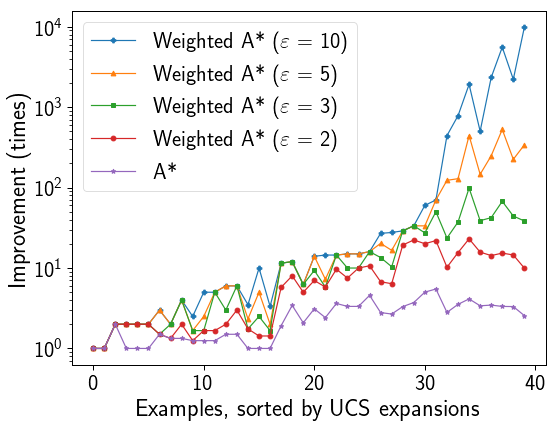

In [18]:
fig, ax = plt.subplots()

for i, eps in reversed(list(enumerate(WEIGHTED_EPSILONS))):
    improv = improvements[eps]
    ax.plot(improv, label='Weighted A* ($\\varepsilon$ = {})'.format(eps),
            marker=MARKERS[i + 2])
    
ax.plot(improvements[1], label='A*', marker=MARKERS[1])
   
ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Improvement (times)')
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    fig.savefig('../out/bots_improvement_bin_%d_band_%s.pdf' % (FOCUS_BINS, BAND))

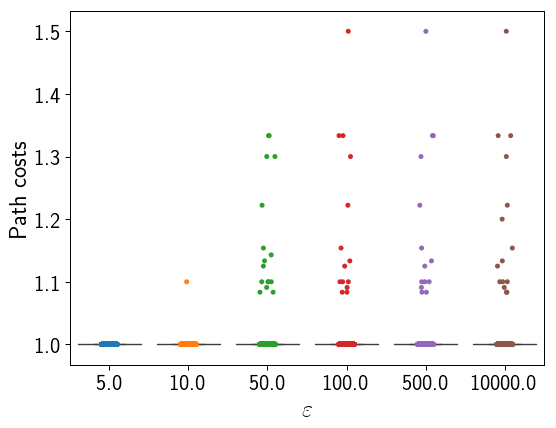

In [19]:
fig, ax = plt.subplots()

data_df = costs_df.query('eps in %s' % [5, 10, 50, 100, 500, 5000, 10000])
sns.boxplot(data=data_df, x='eps', y='pathcostincrease', ax=ax, showfliers=False)
sns.stripplot(data=data_df, x='eps', y='pathcostincrease', ax=ax)

ax.set_ylabel('Path costs')
ax.set_xlabel('$\\varepsilon$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    fig.savefig('../out/bots_path_costs_band_%s.pdf' % BAND)

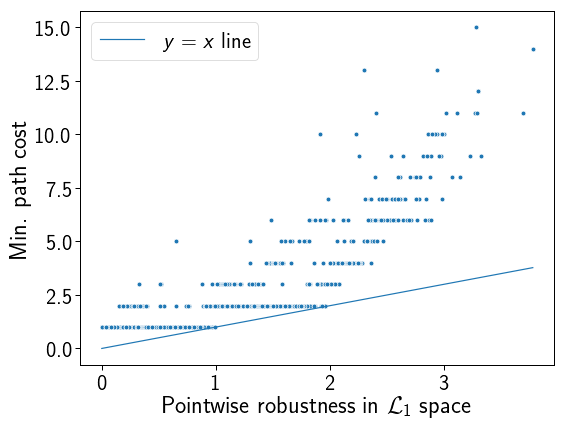

In [20]:
fig, ax = plt.subplots()
ast_costs_df = costs_df.query('eps==1')
sns.scatterplot(data=ast_costs_df,
            x='robustness', y='pathcost', ax=ax)

xs = [ast_costs_df.robustness.min(), ast_costs_df.robustness.max()]
plt.plot(xs, xs, label='$y = x$ line')

ax.legend()
ax.set_xlabel('Pointwise robustness in $\mathcal{L}_%d$ space' % item['p_norm'])
ax.set_ylabel('Min. path cost')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    fig.savefig('../out/bots_mac_comparison_band_%s.pdf' % BAND)